In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
sns.set(color_codes=True)

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [2]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
print("This dataset has {} rows and {} columns.".format(data.shape[0],data.shape[1]))

This dataset has 144 rows and 2 columns.


In [4]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

The data contains a particular month and number of passengers travelling in that month. But this is still not read as a TS object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command.

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col = 'Month', date_parser = dateparse)

In [6]:
data.head(2)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118


In [7]:
data.isnull().sum()

#Passengers    0
dtype: int64

No missing values

### Check Stationarity of a Time Series

A time-series is said to be stationary if its statistical properties satisfy these basic criterion:

##### 1) Mean - The mean of the series should not be a function of time rather should be a constant.
The image below has the left hand graph satisfying the condition whereas the graph in red has a time dependent mean.
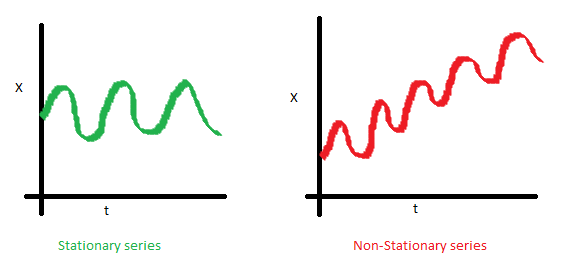

##### 2) Variance - The variance of the series should not a be a function of time. This property is known as homoscedasticity. 
Following graph depicts what is and what is not a stationary series. (Notice the varying spread of distribution in the right hand graph)
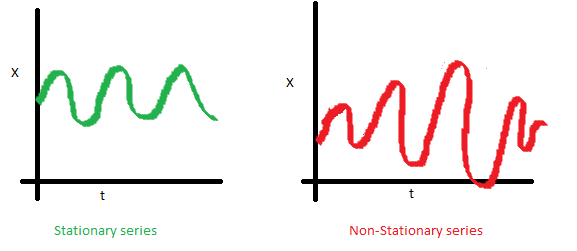

##### 3) Covariance - The covariance of the i th term and the (i + m) th term should not be a function of time
In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’.
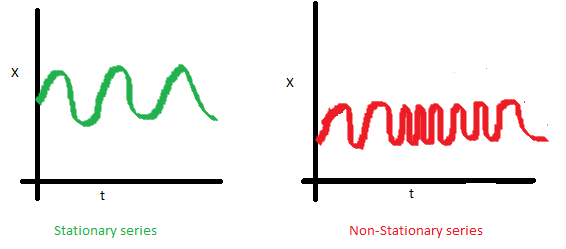

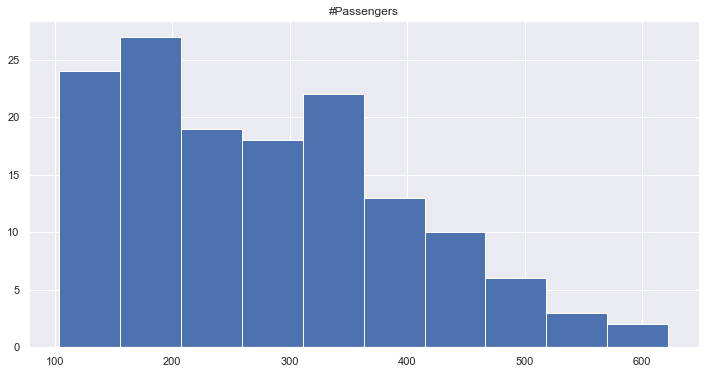

In [8]:
data.hist(figsize= (12,6))
plt.show()

This skewed distribution of the observations is also an indicator of a non-stationary time series.

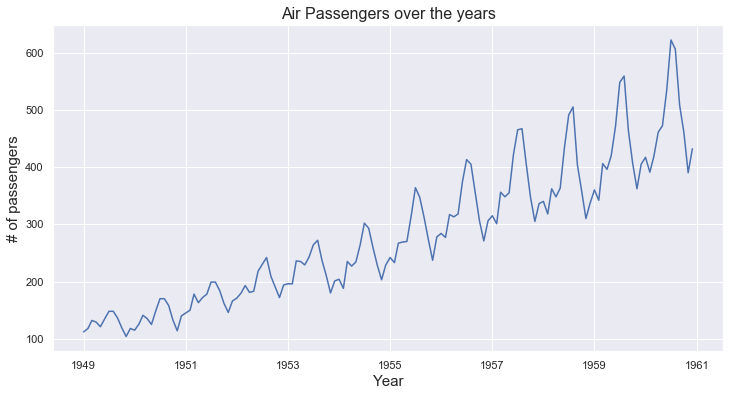

In [9]:
plt.subplots(figsize = (12,6))
plt.plot(data)
plt.title("Air Passengers over the years", fontsize = 16)
plt.ylabel("# of passengers", fontsize = 15)
plt.xlabel("Year",fontsize = 15)
plt.show()

Evidently, there is an overall increasing trend in the data along with some seasonal variations. Checking stationarity of a time series is important because unless the time series is stationary, a predictive time series model cannot be built. In cases where the stationary criterion are violated, the first requisite becomes to stationarize the time series and then try stochastic models to predict this time series.

We will check stationarity using the following:

##### 1) Plotting Rolling Statistics: 
Plot the moving average or moving variance and see if it varies with time. Moving average/variance means that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

##### 2) Dickey-Fuller Test: 
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [10]:
# Change dataframe to series
time_series_data = data['#Passengers']

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() # This is the number of observations used for calculating the statistic
    rolstd  = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.subplots(figsize = (12,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 16)
    plt.ylabel("# of passengers", fontsize = 15)
    plt.xlabel("Year",fontsize = 15)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

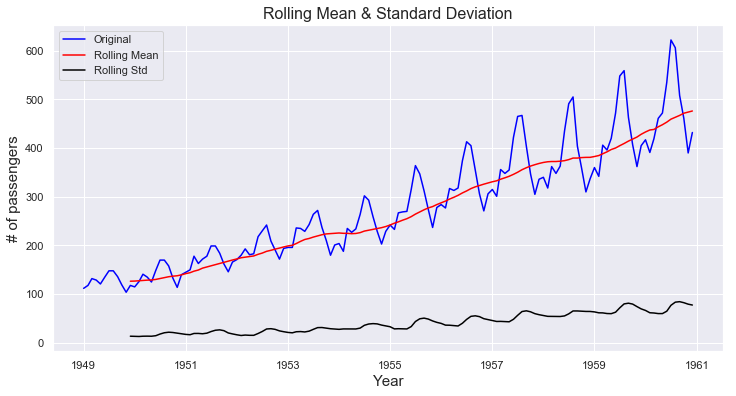

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
test_stationarity(time_series_data)

In the graph, we observe that though the variation in standard deviation is small, mean is clearly increasing with time which shows the data is not a stationary series. Also, the test statistic is way more than the critical values. Note that **the signed values should be compared and not the absolute values**.

### Make a Time Series Stationary

To make a time series stationary, we must first understand what is making the data non-stationary. 

There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. For example, people might have a tendency to buy cars in a particular month because of pay increment or festivals or people tend to take flights more during festivals such as Christmas, Thanksgiving or New Year.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

#### Estimate and eliminate trend

##### Transformation
In this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

In [13]:
ts_log = np.log(time_series_data)

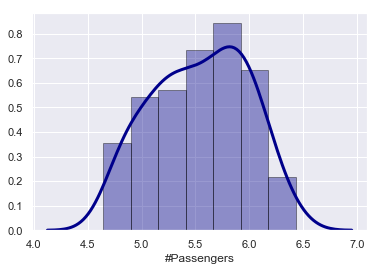

In [14]:
# Density Plot and Histogram
sns.distplot(ts_log, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.show()

##### Moving Average

In statistics, a moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. A **moving average** divides the series into overlapping regions, called **windows**, and computes the average of the values in each window.

One of the simplest moving averages is the **rolling mean**, which computes the mean of the values in each window. For example, if the window size is 3, the rolling mean computes the mean of values 0 through 2, 1 through 3, 2 through 4, etc.

In time series, moving average is used to smooth out short-term fluctuations and highlight longer-term trends or cycles. 

So here, we take average of ‘k’ consecutive values depending on the frequency of time series. We can take the average over the past 1 year, i.e. last 12 values.

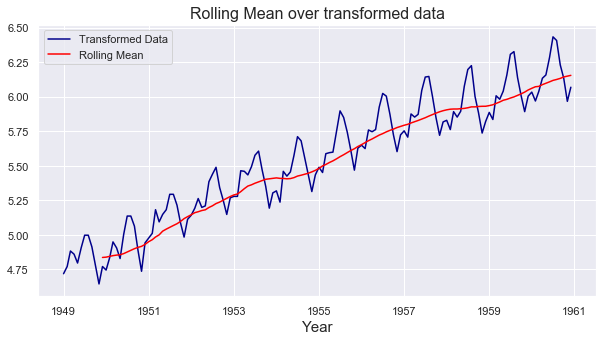

In [15]:
moving_avg = ts_log.rolling(window=12).mean()
plt.subplots(figsize = (10,5))
plt.plot(ts_log, color='darkblue', label='Transformed Data')
plt.plot(moving_avg, color='red', label='Rolling Mean')
plt.title("Rolling Mean over transformed data", fontsize = 16)
plt.xlabel("Year",fontsize = 15)
plt.legend(loc='best')
plt.show()

As we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [16]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

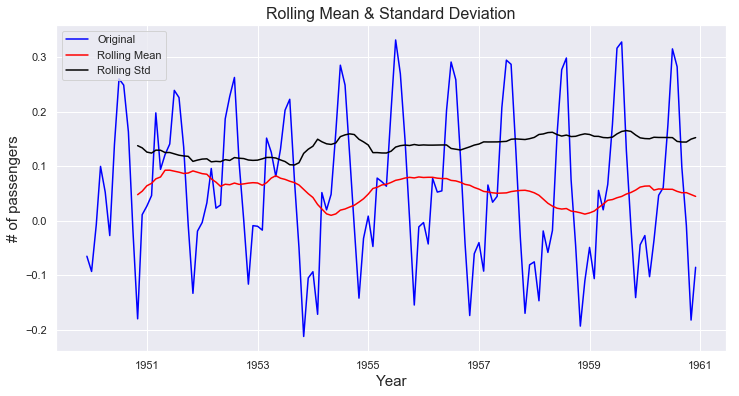

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [17]:
# drop the Nan values
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the **5% critical values** so we can say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a **weighted moving average** where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is **exponentially weighted moving average** where weights are assigned to all the previous values with a decay factor. It has two advantages: 
- First, it computes a weighted average where the most recent value has the highest weight and the weights for previous values drop off exponentially. 
- Second, the pandas implementation of EWMA handles missing values better.

In [18]:
exp_wt_avg = ts_log.ewm(halflife = 12).mean()

The **halflife** parameter is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain.

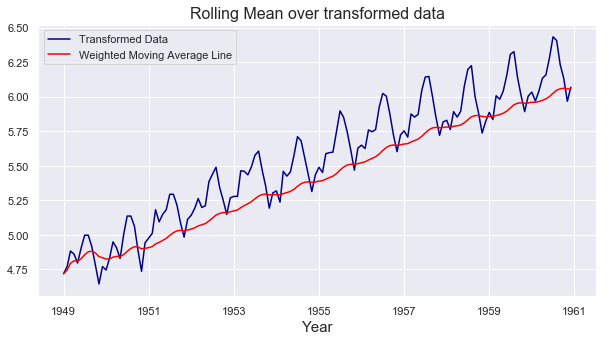

In [19]:
plt.subplots(figsize = (10,5))
plt.plot(ts_log, color='darkblue', label='Transformed Data')
plt.plot(exp_wt_avg, color='red', label='Weighted Moving Average Line')
plt.title("Rolling Mean over transformed data", fontsize = 16)
plt.xlabel("Year",fontsize = 15)
plt.legend(loc='best')
plt.show()

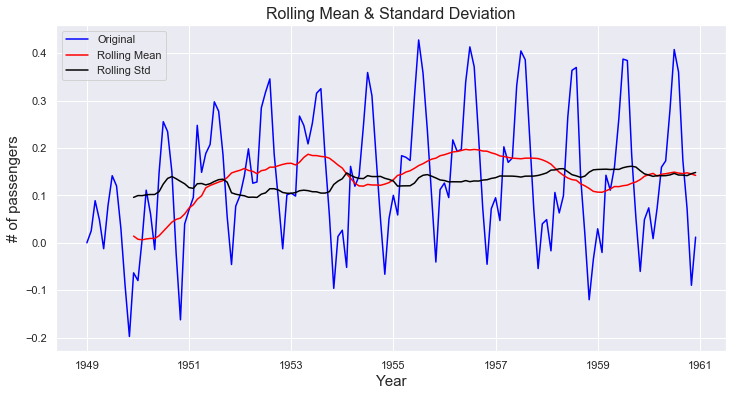

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - exp_wt_avg
test_stationarity(ts_log_ewma_diff)

This time series has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. **In this case there will be no missing values as all values from starting are given weights**.

#### Estimate trend and seasonality

Two ways of removing trend and seasonality:

1. **Differencing** – taking the differece with a particular time lag
2. **Decomposition** – modeling both trend and seasonality and removing them from the model.

We can visualize our data using second method time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

Resampling is the conversion of time series from one frequency to another. Resample the data using frequency as 'MS' for start of the month.

In [21]:
y = time_series_data.resample('MS').mean()

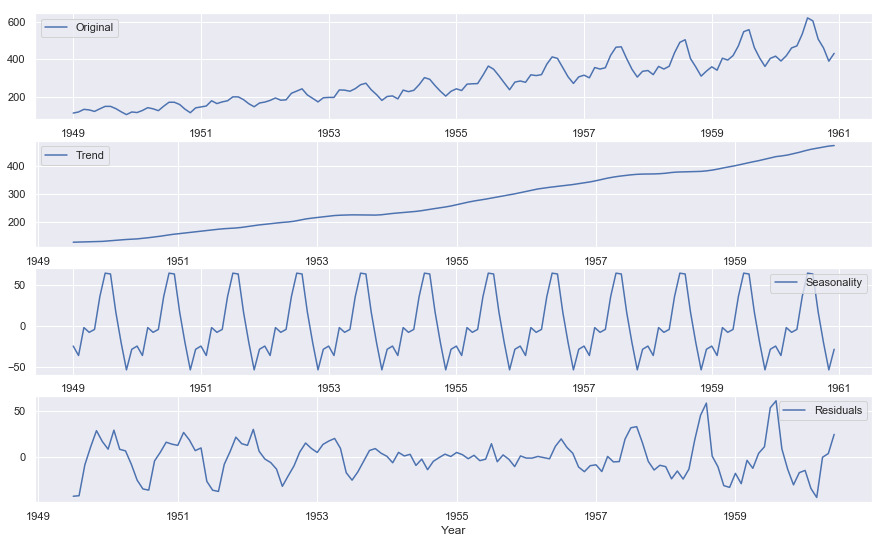

In [22]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,9))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.observed.plot(ax=ax1, label = 'Original', legend= True)
decomposition.trend.plot(ax=ax2, label = 'Trend', legend= True)
decomposition.seasonal.plot(ax=ax3, label = 'Seasonality', legend= True)
decomposition.resid.plot(ax=ax4, label = 'Residuals', legend= True)
plt.xlabel('Year')
plt.show()

A time series that has patterns that repeat over known and fixed periods of time is said to have seasonality. Seasonality is a general term for variations that periodically repeat in data. In general, we think of variations as 4 categories: Seasonal, Cyclic, Trend, and Irregular fluctuations.

From the above plot, we can clearly see the seasonal component of the data, and we can also see the separated upward trend of the data.

Trends can be upward or downward, and can be linear or non-linear. It is important to understand the data set to know whether or not a significant period of time has passed to identify an actual trend.

### Forecasting a Time Series using ARIMA model

ARIMA stands for **Auto-Regressive Integrated Moving Averages**. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. 

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

**p** is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, we state its likely that it will rain tomorrow as well.

**d** is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. We can imagine an example of this as forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.

**q** is the parameter associated with the moving average part of the model.

If the data has a seasonal component, we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P,D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model.

There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc. One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The **Akaike information criterion (AIC)** is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

In [23]:
p = d = q = range(0, 2)
pdq = tuple(itertools.product(p, d, q))
seasonal_pdq = tuple((x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q)))
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### ARIMA without transformed data

In [24]:
df = pd.DataFrame(columns=['Order','Seasonal Order','AIC'])
order = []
seasonal_order = []
aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            order.append(param)
            seasonal_order.append(param_seasonal)
            aic.append(results.aic)
        except:
            continue
            
df['Order'] = order
df['Seasonal Order'] = seasonal_order
df['AIC'] = aic

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

In [25]:
o = df[df['AIC'] == min(df['AIC'])]['Order'].reset_index(drop=True)
so = df[df['AIC'] == min(df['AIC'])]['Seasonal Order'].reset_index(drop=True)
print(df[df['AIC'] == min(df['AIC'])])

mod = sm.tsa.statespace.SARIMAX(y,
                                order=o[0],
                                seasonal_order=so[0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('\n',results.summary().tables[1])

        Order Seasonal Order         AIC
31  (0, 1, 1)  (1, 1, 1, 12)  920.319297

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3351      0.076     -4.403      0.000      -0.484      -0.186
ar.S.L12      -0.5597      0.285     -1.967      0.049      -1.117      -0.002
ma.S.L12       0.4077      0.336      1.212      0.225      -0.251       1.067
sigma2       140.2869     18.080      7.759      0.000     104.852     175.722


The **summary** attribute that results from the output of SARIMAX returns a significant amount of information. The **coef** column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The **P>|z|** column informs us of the significance of each feature weight.

*Residuals* are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:
1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean i.e. normally distributed. If the residuals have a mean other than zero, then the forecasts are biased.

So, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The **plot_diagnostics** object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

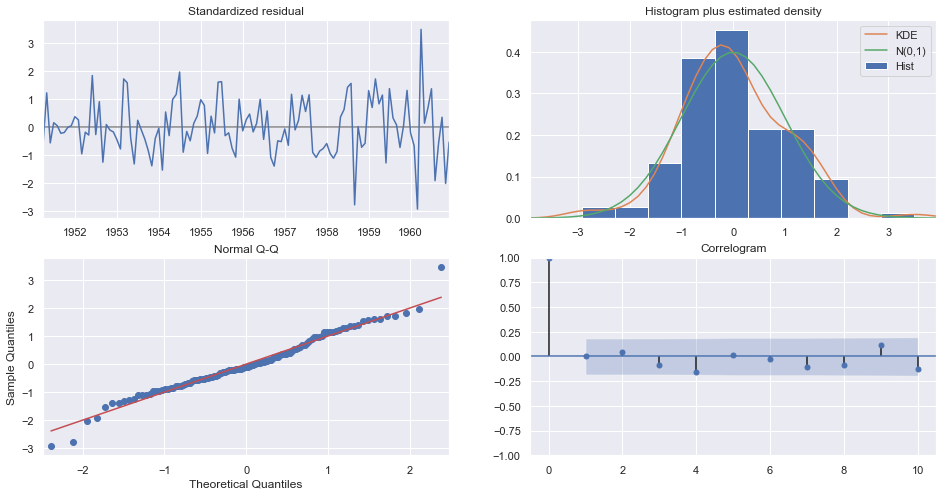

In [26]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

- In the top right plot, we see that the orange KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

In [27]:
# Split the data into train and test
train = y.loc['1949-01-01':'1958-12-01']
test = y.loc['1959-01-01':]

results = mod.fit(train)

The dataset is split into training and test set and the model is fit into training set. Test set values are predicted and compared to real values of the time series, which will help us understand the accuracy of our forecasts. The *get_prediction()* and *conf_int()* attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

The *dynamic=False* argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

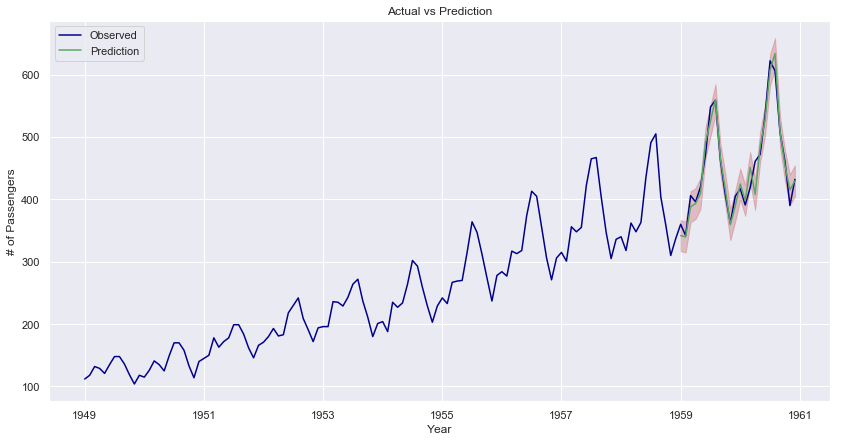

In [28]:
pred = results.get_prediction(start = pd.to_datetime(test.index[0]), dynamic = False)
pred_ci = pred.conf_int()
ax = y.plot(label='Observed', color = 'darkblue')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=1, figsize=(14, 7), color = 'g')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.3)
ax.set_xlabel('Year')
ax.set_ylabel('# of Passengers')
ax.set_title('Actual vs Prediction')
plt.legend()
plt.show()

Overall, our forecasts align well with the true values, showing an overall increase trend.

It is also useful to quantify the accuracy of the forecasts. We will use the **MSE (Mean Squared Error)**, which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean. **The smaller the MSE, the closer we are to the line of best fit**.

In [29]:
y_forecasted = pred.predicted_mean
y_truth = test
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 324.7
The Root Mean Squared Error of our forecasts is 18.02


With *dynamic=True* argument, we get forecasts based on information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

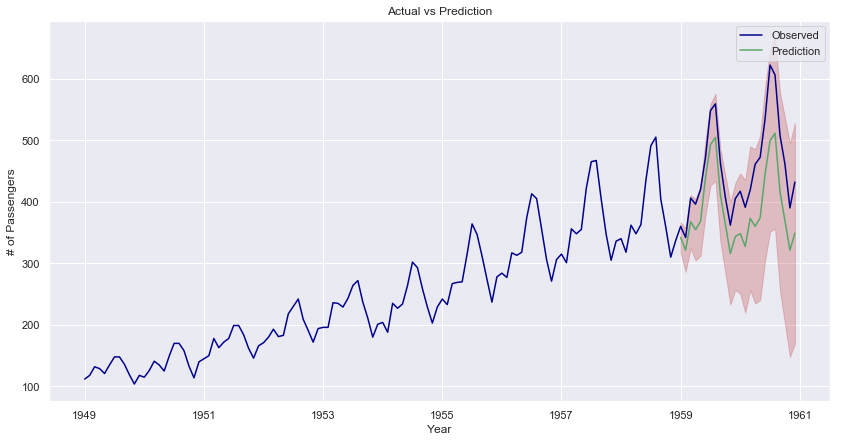

In [30]:
pred = results.get_prediction(start = pd.to_datetime(test.index[0]), dynamic = True, full_results=True)
pred_ci = pred.conf_int()
ax = y.plot(label='Observed', color = 'darkblue')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=1, figsize=(14, 7), color = 'g')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.3)
ax.set_xlabel('Year')
ax.set_ylabel('# of Passengers')
ax.set_title('Actual vs Prediction')
plt.legend()
plt.show()

In [31]:
y_forecasted = pred.predicted_mean
y_truth = test
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 4818.89
The Root Mean Squared Error of our forecasts is 69.42


However, dynamic forecasting does not seem to work well as it ends up increasing our MSE.

### ARIMA with transformed data

Now, we will repeat the above steps with our transformed dataset and see the results.

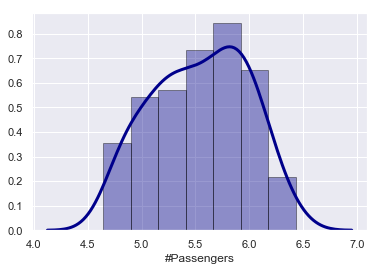

In [14]:
# Density Plot and Histogram
sns.distplot(ts_log, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.show()

In [32]:
y1 = ts_log.resample('MS').mean()

In [33]:
df = pd.DataFrame(columns=['Order','Seasonal Order','AIC'])
order = []
seasonal_order = []
aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            order.append(param)
            seasonal_order.append(param_seasonal)
            aic.append(results.aic)
        except:
            continue
            
df['Order'] = order
df['Seasonal Order'] = seasonal_order
df['AIC'] = aic

o = df[df['AIC'] == min(df['AIC'])]['Order'].reset_index(drop=True)
so = df[df['AIC'] == min(df['AIC'])]['Seasonal Order'].reset_index(drop=True)
print(df[df['AIC'] == min(df['AIC'])])

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=o[0],
                                seasonal_order=so[0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('\n',results.summary().tables[1])

        Order Seasonal Order         AIC
45  (1, 0, 1)  (1, 0, 1, 12) -477.619384

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.101      0.000       0.865       1.018
ma.L1         -0.3804      0.093     -4.093      0.000      -0.563      -0.198
ar.S.L12       1.0200      0.003    302.562      0.000       1.013       1.027
ma.S.L12      -0.5747      0.107     -5.387      0.000      -0.784      -0.366
sigma2         0.0013      0.000      9.240      0.000       0.001       0.002


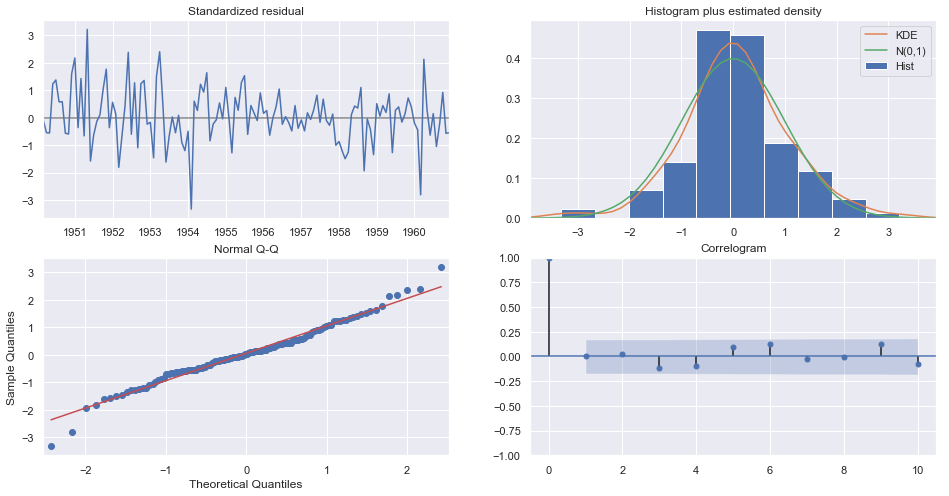

In [34]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

We see that the top right plot of histogram shows, a much clearer view of a normally distributed data when compared to the previous one.

In [35]:
# Split the data into train and test
train = y1.loc['1949-01-01':'1958-12-01']
test = y1.loc['1959-01-01':]

results = mod.fit(train)

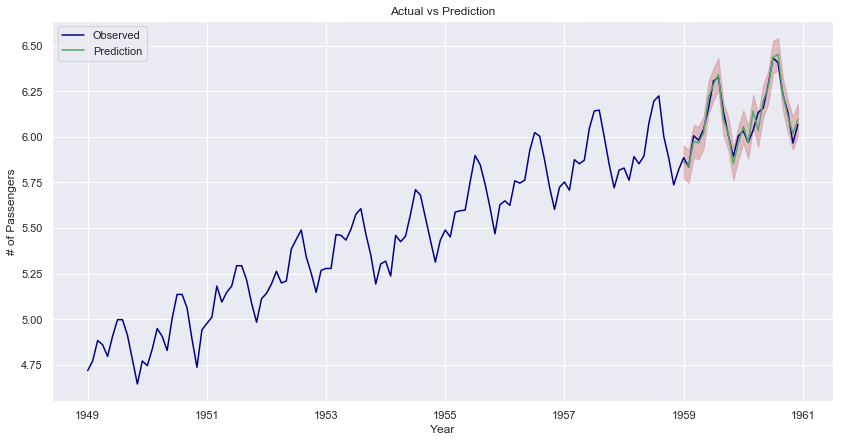

The Mean Squared Error of our forecasts is 0.0
The Root Mean Squared Error of our forecasts is 0.04


In [36]:
pred = results.get_prediction(start = pd.to_datetime(test.index[0]), dynamic = False)
pred_ci = pred.conf_int()
ax = y1.plot(label='Observed', color = 'darkblue')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=1, figsize=(14, 7), color = 'g')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.3)
ax.set_xlabel('Year')
ax.set_ylabel('# of Passengers')
ax.set_title('Actual vs Prediction')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
y_truth = test
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The MSE has come down to 0.

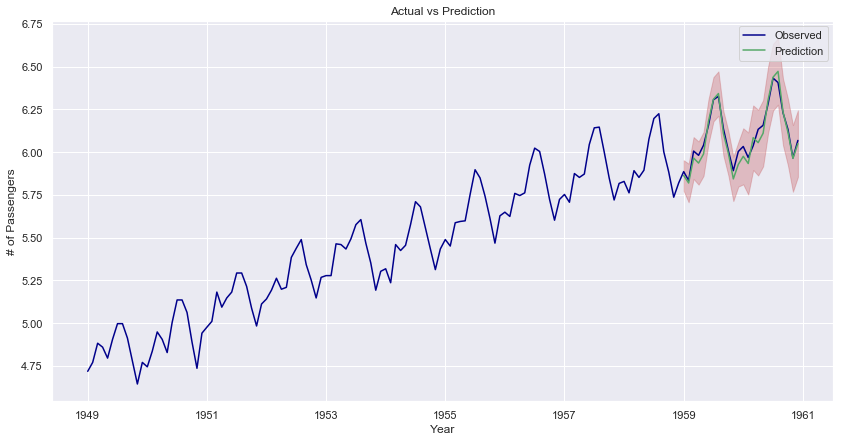

The Mean Squared Error of our forecasts is 0.0
The Root Mean Squared Error of our forecasts is 0.04


In [38]:
pred = results.get_prediction(start = pd.to_datetime(test.index[0]), dynamic = True, full_results=True)
pred_ci = pred.conf_int()
ax = y1.plot(label='Observed', color = 'darkblue')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=1, figsize=(14, 7), color = 'g')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.3)
ax.set_xlabel('Year')
ax.set_ylabel('# of Passengers')
ax.set_title('Actual vs Prediction')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
y_truth = test
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In this case, dynamic forecastong is working very well.

### References

- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3